## Detect les couleurs en prenant en compte les images en paramètres 

In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def extract_colors_from_decalque(img, n_colors=5, show=False):
    """
    Extrait les couleurs principales d'un décalque (image).

    Args:
        img: Image BGR (chargée avec OpenCV).
        n_colors (int): Nombre de couleurs dominantes à extraire.
        show (bool): Affiche ou non les couleurs détectées.

    Returns:
        colors (list): Liste des couleurs en format RGB.
    """
    if img is None:
        raise ValueError("Image vide reçue.")

    # Convertir en RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Option : redimensionner pour aller plus vite
    img_small = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_AREA)

    # Aplatir en une liste de pixels
    pixels = img_small.reshape(-1, 3)

    # Enlever les pixels proches du blanc
    pixels = pixels[np.all(pixels < [245, 245, 245], axis=1)]
    if len(pixels) == 0:
        raise ValueError("Pas de pixels valides détectés (image blanche ?)")

    # Protection : si peu de pixels valides, adapter n_clusters
    n_clusters = min(n_colors, len(pixels))

    # Clustering pour trouver les couleurs principales
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)

    if show:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        for i, color in enumerate(colors):
            plt.bar(i, 1, color=np.array(color)/255.0, width=1)
        plt.xticks([])
        plt.yticks([])
        plt.title('Couleurs détectées')
        plt.tight_layout()
        plt.show()

    return [tuple(color) for color in colors]


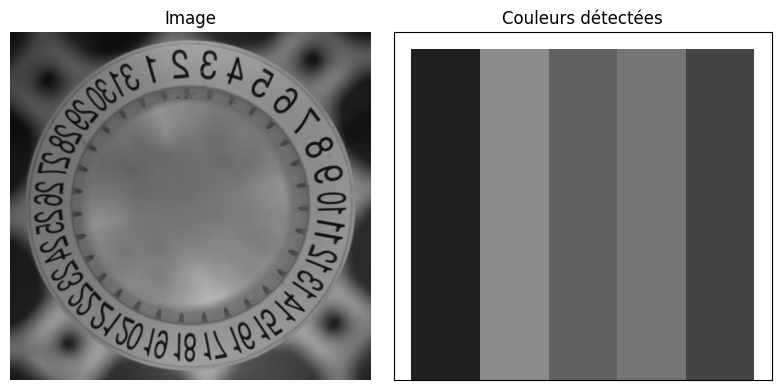

Couleurs détectées (RGB) :
Couleur 1 : (31, 31, 31)
Couleur 2 : (140, 140, 140)
Couleur 3 : (96, 96, 96)
Couleur 4 : (117, 117, 117)
Couleur 5 : (68, 68, 68)


In [2]:
image_path = 'data/sans_rayure/aug_3497.png'
img = cv2.imread(image_path)

colors = extract_colors_from_decalque(img, n_colors=5, show=True)

print("Couleurs détectées (RGB) :")
for idx, color in enumerate(colors):
    print(f"Couleur {idx+1} : {color}")


## Convertir dxf en image 

Erreur lors de la conversion du DXF en tableau : module 'matplotlib.pyplot' has no attribute 'Arc'


AttributeError: module 'matplotlib.pyplot' has no attribute 'Arc'

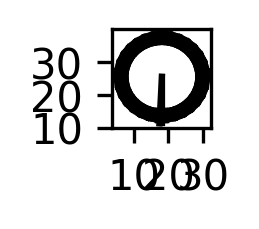

In [4]:
# Vérification des dépendances
try:
    import ezdxf
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.backends.backend_agg import FigureCanvasAgg
except ImportError as e:
    print(f"Erreur : Une dépendance est manquante. Assurez-vous d'avoir installé les bibliothèques nécessaires.")
    print("Installez-les avec :")
    print("pip install ezdxf matplotlib numpy")
    raise e

# Fonction pour convertir un fichier DXF en tableau NumPy (image)
def dxf_to_array(dxf_path, dpi=300, size=(128, 128)):
    try:
        # Charger le fichier DXF
        doc = ezdxf.readfile(dxf_path)
        msp = doc.modelspace()  # Espace de modèle (modelspace) où se trouvent les entités

        # Créer une figure pour dessiner
        fig, ax = plt.subplots(figsize=(size[0]/dpi, size[1]/dpi), dpi=dpi)

        # Parcourir toutes les entités dans le modelspace
        for entity in msp:
            # Dessiner les lignes
            if entity.dxftype() == 'LINE':
                start = entity.dxf.start
                end = entity.dxf.end
                ax.plot([start.x, end.x], [start.y, end.y], 'k-')  # Ligne noire

            # Dessiner les cercles
            elif entity.dxftype() == 'CIRCLE':
                center = entity.dxf.center
                radius = entity.dxf.radius
                circle = plt.Circle((center.x, center.y), radius, fill=False, color='k')
                ax.add_patch(circle)

            # Dessiner les polylignes
            elif entity.dxftype() == 'LWPOLYLINE':
                points = entity.get_points('xy')
                x, y = zip(*points)
                ax.plot(x, y, 'k-')

            # Dessiner les arcs
            elif entity.dxftype() == 'ARC':
                center = entity.dxf.center
                radius = entity.dxf.radius
                start_angle = entity.dxf.start_angle
                end_angle = entity.dxf.end_angle
                arc = plt.Arc((center.x, center.y), radius * 2, radius * 2, 
                              theta1=start_angle, theta2=end_angle, color='k')
                ax.add_patch(arc)

            # Ajouter d'autres types d'entités si nécessaire (TEXT, etc.)

        # Ajuster les limites de l'image
        ax.autoscale()
        ax.set_aspect('equal')  # Garder les proportions égales
        ax.axis('off')  # Désactiver les axes

        # Convertir la figure en tableau NumPy
        canvas = FigureCanvasAgg(fig)
        canvas.draw()
        # Obtenir le tableau NumPy (RGB)
        img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
        img_array = img_array.reshape(canvas.get_width_height()[::-1] + (3,))

        # Convertir en niveaux de gris
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

        # Redimensionner à la taille souhaitée (par exemple 128x128)
        img_array = cv2.resize(img_array, size, interpolation=cv2.INTER_AREA)

        # S'assurer que le fond est noir (inverser si nécessaire)
        img_array = 255 - img_array  # Inverser : lignes blanches, fond noir
        img_array[img_array < 255] = 0  # Forcer le fond à être noir

        plt.close(fig)
        return img_array

    except Exception as e:
        print(f"Erreur lors de la conversion du DXF en tableau : {e}")
        raise e

# Exemple d'utilisation
dxf_path = 'data/dxf/79170_E-01_[79170_E-01].dxf'  # Remplacez par le chemin de votre fichier DXF
image_array = dxf_to_array(dxf_path, dpi=300, size=(128, 128))

# Afficher la forme du tableau pour vérification
print(f"Forme du tableau de l'image : {image_array.shape}")

# Optionnel : Afficher l'image pour vérification
import matplotlib.pyplot as plt
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.show()

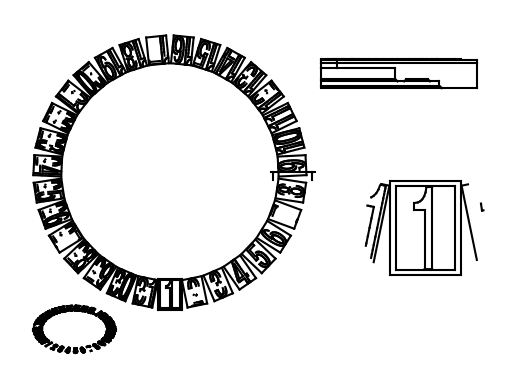

In [14]:
import ezdxf
import matplotlib.pyplot as plt

def show_dxf_image(dxf_path):
    # Charger le fichier DXF
    doc = ezdxf.readfile(dxf_path)
    msp = doc.modelspace()

    # Créer une figure
    fig, ax = plt.subplots()

    # Parcourir les entités du modèle
    for e in msp:
        if e.dxftype() == 'LINE':
            start = e.dxf.start
            end = e.dxf.end
            ax.plot([start[0], end[0]], [start[1], end[1]], color='black')

    # Ajuster l'affichage
    ax.axis('equal')  # Échelle égale pour X et Y
    ax.axis('off')    # Cacher les axes

    # Afficher l'image directement
    plt.show()

# Exemple d'utilisation
dxf_path = 'data/dxf/388679_A-04_[388679_A-04].dxf'
show_dxf_image(dxf_path)


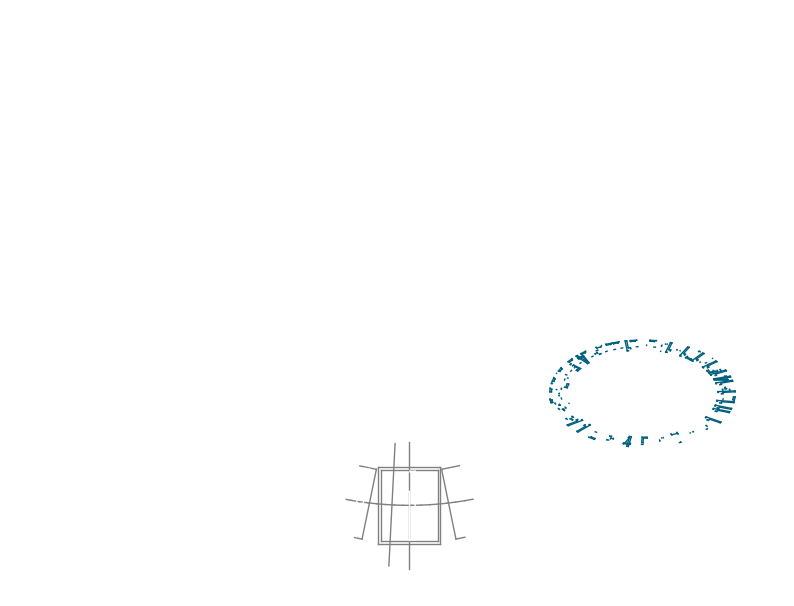

In [13]:
import ezdxf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_entity_color(entity, doc):
    """
    Récupère la couleur RGB d'une entité, même si héritée du layer.
    """
    color_index = entity.dxf.color

    if color_index == 256:  # "ByLayer"
        layer_name = entity.dxf.layer
        layer = doc.layers.get(layer_name)
        color_index = layer.color

    # Conversion index ACI → RGB
    from ezdxf.colors import aci2rgb  # Import ici si besoin
    return aci2rgb(color_index)  # appel direct

def plot_dxf_entities(doc):
    """
    Affiche les entités du DXF avec leurs vraies couleurs.
    """
    msp = doc.modelspace()

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')
    ax.axis('off')  # Correction ici aussi : 'set_axis_off()' → 'axis("off")'

    for entity in msp:
        color_rgb = get_entity_color(entity, doc)
        color_norm = tuple(c / 255 for c in color_rgb)  # Normaliser pour Matplotlib

        if entity.dxftype() == 'LINE':
            start = entity.dxf.start
            end = entity.dxf.end
            ax.plot([start.x, end.x], [start.y, end.y], color=color_norm, linewidth=1)

        elif entity.dxftype() == 'CIRCLE':
            center = entity.dxf.center
            radius = entity.dxf.radius
            circle = patches.Circle((center.x, center.y), radius, edgecolor=color_norm, facecolor='none')
            ax.add_patch(circle)

        elif entity.dxftype() == 'LWPOLYLINE':
            points = [(point[0], point[1]) for point in entity.get_points()]
            xs, ys = zip(*points)
            ax.plot(xs, ys, color=color_norm, linewidth=1)

        # Tu peux ajouter ici d'autres entités comme ARC, SPLINE, etc.

    plt.show()

# ======== Exécution =========
dxf_file_path = 'data/dxf/79170_E-01_[79170_E-01].dxf'
doc = ezdxf.readfile(dxf_file_path)
plot_dxf_entities(doc)


## Detect les couleurs en prenant en compte un dossier contenant les images en paramètres 


Image : blanc_entier_0.jpg


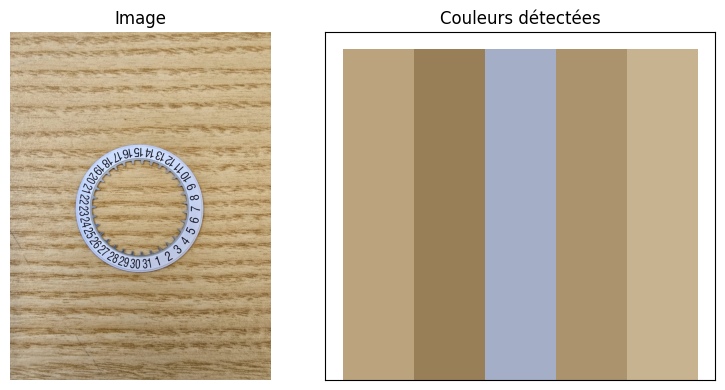

Couleurs (RGB) extraites :
  Couleur 1 : (187, 163, 125)
  Couleur 2 : (152, 127, 88)
  Couleur 3 : (164, 174, 198)
  Couleur 4 : (170, 147, 109)
  Couleur 5 : (200, 179, 144)

Image : blanc_entier_fond_blanc_0.png


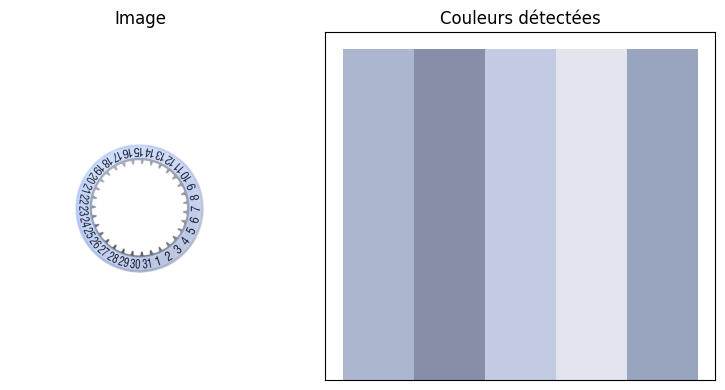

Couleurs (RGB) extraites :
  Couleur 1 : (172, 183, 207)
  Couleur 2 : (134, 143, 167)
  Couleur 3 : (194, 203, 225)
  Couleur 4 : (227, 229, 236)
  Couleur 5 : (153, 164, 190)

Image : blanc_rogner_0.jpg


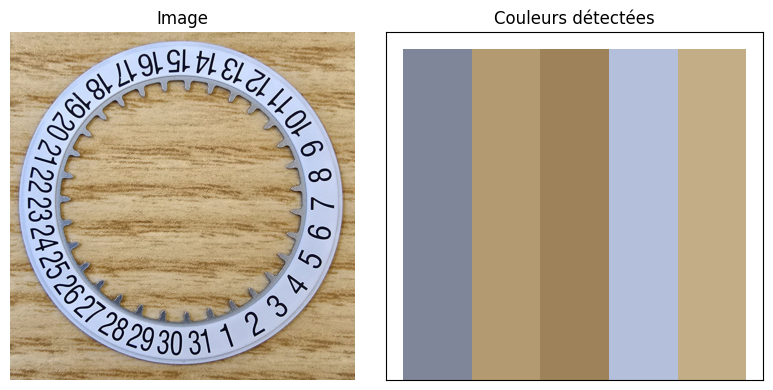

Couleurs (RGB) extraites :
  Couleur 1 : (128, 134, 153)
  Couleur 2 : (180, 154, 113)
  Couleur 3 : (158, 130, 89)
  Couleur 4 : (180, 192, 219)
  Couleur 5 : (195, 173, 135)

Image : blanc_rogner_fond_blanc_0.png


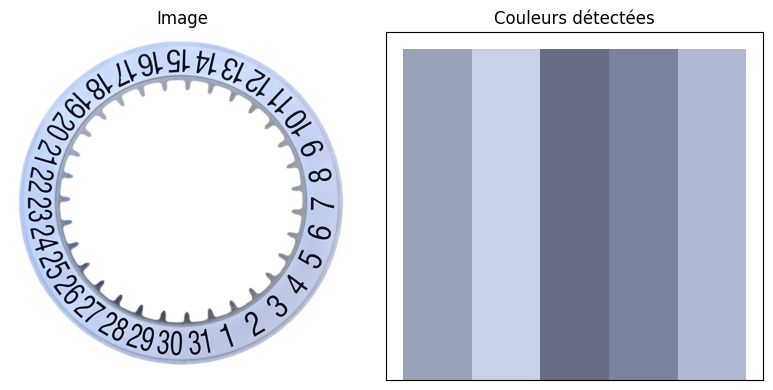

Couleurs (RGB) extraites :
  Couleur 1 : (151, 161, 183)
  Couleur 2 : (199, 209, 232)
  Couleur 3 : (101, 108, 131)
  Couleur 4 : (122, 131, 155)
  Couleur 5 : (176, 187, 211)

Image : noir_entier_0.jpg


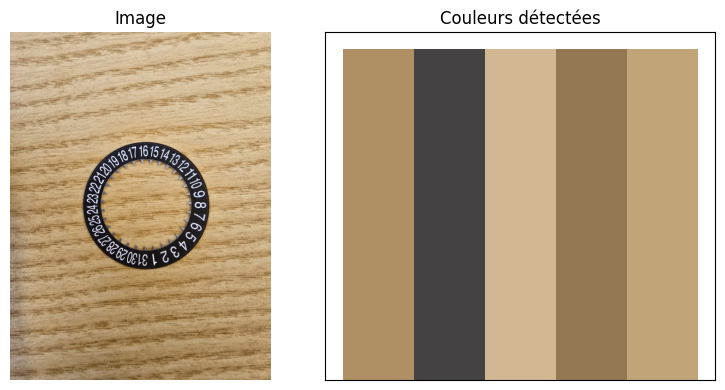

Couleurs (RGB) extraites :
  Couleur 1 : (174, 144, 100)
  Couleur 2 : (69, 66, 68)
  Couleur 3 : (209, 184, 147)
  Couleur 4 : (147, 120, 81)
  Couleur 5 : (193, 164, 120)

Image : noir_entier_fond_blanc_0.png


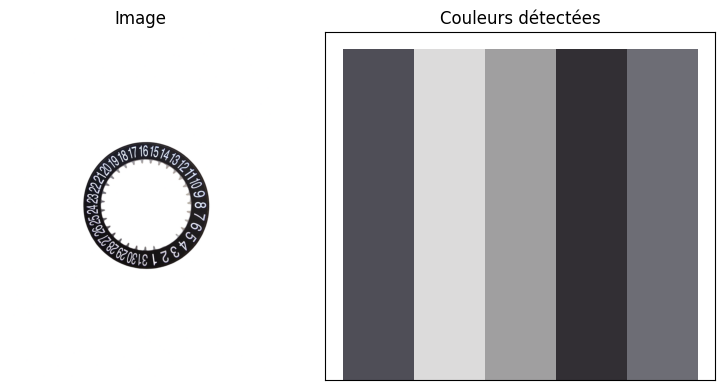

Couleurs (RGB) extraites :
  Couleur 1 : (79, 78, 87)
  Couleur 2 : (220, 219, 219)
  Couleur 3 : (160, 159, 160)
  Couleur 4 : (50, 47, 52)
  Couleur 5 : (109, 109, 117)

Image : noir_rogner_0.jpg


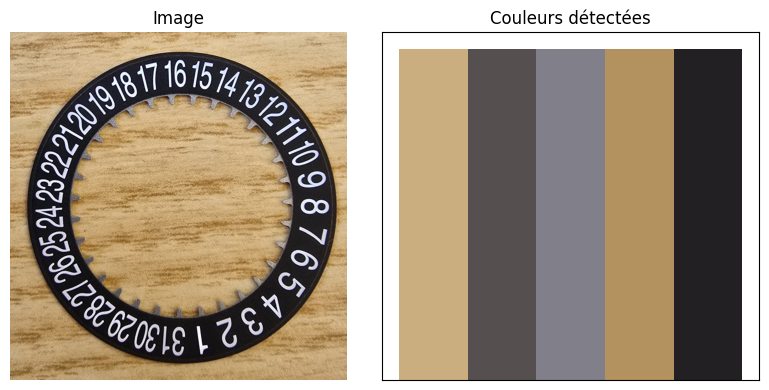

Couleurs (RGB) extraites :
  Couleur 1 : (203, 174, 127)
  Couleur 2 : (86, 79, 79)
  Couleur 3 : (129, 128, 138)
  Couleur 4 : (180, 146, 95)
  Couleur 5 : (34, 32, 35)

Image : noir_rogner_fond_blanc_0.png


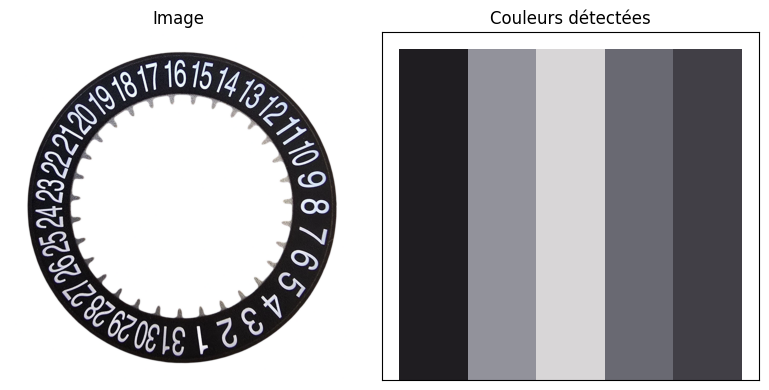

Couleurs (RGB) extraites :
  Couleur 1 : (31, 29, 33)
  Couleur 2 : (146, 146, 155)
  Couleur 3 : (216, 214, 215)
  Couleur 4 : (105, 105, 114)
  Couleur 5 : (65, 63, 70)


In [3]:
import os
import cv2
import matplotlib.pyplot as plt

def test_extract_colors_on_folder(folder_path, n_colors=5):
    """
    Teste l'extraction des couleurs sur toutes les images d'un dossier.

    Args:
        folder_path (str): Chemin vers le dossier contenant les images.
        n_colors (int): Nombre de couleurs dominantes à extraire pour chaque image.
    """
    if not os.path.exists(folder_path):
        raise ValueError(f"Le dossier {folder_path} n'existe pas.")

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) == 0:
        print("Aucune image trouvée dans le dossier.")
        return

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Impossible de charger l'image : {img_file}")
            continue
        
        print(f"\nImage : {img_file}")

        # Afficher l'image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title('Image')
        plt.axis('off')

        # Extraire et afficher les couleurs
        try:
            colors = extract_colors_from_decalque(img, n_colors=n_colors, show=False)
            plt.subplot(1, 2, 2)
            for i, color in enumerate(colors):
                plt.bar(i, 1, color=np.array(color)/255.0, width=1)
            plt.xticks([])
            plt.yticks([])
            plt.title('Couleurs détectées')
            plt.tight_layout()
            plt.show()

            print("Couleurs (RGB) extraites :")
            for idx, color in enumerate(colors):
                print(f"  Couleur {idx+1} : {color}")

        except Exception as e:
            print(f"Erreur lors de l'extraction des couleurs pour {img_file} : {e}")

# Chemin vers le dossier contenant les images
folder_path = 'data/image_test/sans_rayure'
test_extract_colors_on_folder(folder_path, n_colors=5)